This is the fifth simple toy model to adapt the LLH NN from Ice Cube to tracker geometry. We're using a more realistic detector model now with 32 detector layers separated into 32 bins. The layers are stacked straight, not following the curve of the ring, and tracks are curved. Each bin only registers hit/no hit, with 100% efficiency. Assume hits are still Gaussian distributed before registering. Instead of using (z,p,phi), we are now using (x,z,p) and assume that phi=0 always.

Training on large parameter range with 1e6 samples.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf

from scipy import stats
from scipy import constants
from scipy.special import erf
import types
from scipy.optimize import minimize, Bounds

from LLH_NN_utils import *

In [2]:
#layers at fixed z, giving x position
#source has x,z,px,pz
# B=1.45

#each tracker module has 4 layers of 32 straws, 8 modules in a station
#straw tube is 5mm diameter
#muons decay 5-10m from first layer
#momentum (0.5-3)e3 MeV
#300 mu-m radial position resolution
#4cm between outer layers of one module
#~6cm from center of module to edge?
#1mm between the two U-layers


#layers of 32 5mm bins, 1mm separated, 1cm between "twin" layers
#
# __ __ __ __
#__ __ __ __
#
#__ __ __ __
# __ __ __ __

#2cm between U and V, 4cm between modules

det_zs = np.ones((8,4))
det_zs[:,0] *= 0
det_zs[:,2] *= 3
det_zs[:,3] *= 4
for i in range(1,8):
    det_zs[i] += i*8
det_zs = det_zs.flatten()*1e-2
    
N_bins = 32
N_det = len(det_zs)

det_xs = np.tile(np.array([(i*6+2.5)*1e-3 for i in range(32)]),(N_det,1)) #i = z, j = x
#leftshift_idx = [1,2,5,6,9,10,13,14] #i//2 even and i%2 odd or i//2 odd and i%2 even
det_xs[[((i//2)%2 == 0 and (i%2) == 1) or ((i//2)%2 == 1 and (i%2) == 0) for i in range(N_det)]] -= 2.5e-3
det_xs += (4.5 + 2)*1e-2 #distance to storage volume center

### Tracker toy model

Muon decaying at (x,z), producing positron with momentum p in z-direction. $\vec{B} = B\hat{y}$

Since the Lorentz force only acts perpendicular to the direction of motion, $|v|$ and $\gamma$ don't change, and the time derivative is simply
$\frac{d\vec{v}}{dt} = \frac{q}{\gamma m} (\vec{v} \times \vec{B}) = \frac{qB}{\gamma m} (v_x \hat{z} - v_z\hat{x})$

$p_x = p\sin(\frac{qB}{\gamma m} t)$<br/>
$p_z = p\cos(\frac{qB}{\gamma m} t)$

$x = \int_0^T v_x dt = -\frac{\gamma m}{qB} |v| (\cos(\frac{qB}{\gamma m} T) - \frac{v_z(0)}{|v|})$<br/>
$z = \int_0^T v_z dt = \frac{\gamma m}{qB} |v| (\sin(\frac{qB}{\gamma m} T) - \frac{v_x(0)}{|v|})$

$z$ is fixed, so<br/>
$T = \frac{\gamma m}{qB}\arcsin(\frac{qBz +\gamma mv_x(0)}{\gamma m |v|})$

$x = \frac{\gamma m v_z(0)}{qB} - \frac{\gamma m|v|}{qB}\cos(\arcsin(\frac{qBz +\gamma mv_x(0)}{\gamma m |v|})) = \frac{\gamma m v_z(0)}{qB} - \frac{\gamma m|v|}{qB}\sqrt{1 - (\frac{qBz +\gamma mv_x(0)}{\gamma m |v|})^2} = \frac{\gamma m v_z(0)}{qB} - \frac{1}{qB}\sqrt{\gamma^2m^2|v|^2 - (qBz +\gamma mv_x(0))^2}$<br/>
$x = \frac{\gamma m v_z(0)}{qB} - \frac{1}{qB}\sqrt{\gamma^2m^2v_z^2(0) - q^2B^2z^2 -2qBz\gamma mv_x(0)} = \frac{p_z(0)}{qB} - \frac{1}{qB}\sqrt{p_z^2(0) - q^2B^2z^2 -2qBzp_x(0)}$

Change to use $|p|(0) = p$ and initial angle $\phi = 0$ (from the z-axis):<br/>
$x = \frac{p}{qB} - \frac{1}{qB}\sqrt{p^2 - q^2B^2z^2} + x(0) = \frac{p}{qB}(1 - \sqrt{1 - \frac{q^2B^2z^2}{p^2}}) + x(0)$

In [16]:
#leave out e in momentum calc, and q's above

c = constants.c
#e = constants.e
B = 1.45

def calc_x(x,z,p):
    # p is in GeV -> *1e9/c
    p = p*1e9/c
    
    sq = p**2 - B**2*z**2
    #take square root where possible
    sq[sq>=0] = np.sqrt(sq[sq>=0])
    
    res = (p - sq)/B + x
    res[sq<0] = -1

    return res

#x position is normal distribution
x_hit = lambda x,sigma: stats.norm(loc=x, scale=sigma)

#example event x_toy,z_toy,p_toy
toy=[1e-3,-0.73,1.9] #this produces hits in almost every layer
#toy=[-1e-2,-0.64,2.3] #this is a flat event, leaving top layers w/o hits
x_toy, z_toy, p_toy = toy

#for Gaussian
sigma = 3e-4

In [4]:
def generate_event(x, z, p):
    # generates an event from given x, z, p
    # returns length N_det array of centers of hit bins
    
    hits = np.zeros(N_det)
    dist = det_zs-z
    x_exp = calc_x(x,dist,p)
    for i in range(N_det):
        x_meas = x_hit(x_exp[i],sigma).rvs()
        #check if x_exp < or > than end of detector (incl. -1)
        if x_meas < det_xs[i,0]-2.5e-3 or x_meas > det_xs[i,-1]+2.5e-3: continue
        
        #figure out which bin it would hit
        j = (np.abs(det_xs[i] - x_meas)).argmin()
        if np.abs(x_meas-det_xs[i,j]) <= 2.5e-3:
            hits[i] = det_xs[i,j]
    return hits

#toy MC
def MC_events(N_events, xlims=(-2.5e-2,2.5e-2), zlims=(-1, -0.5), plims=(0.5,3.0), verbose_lvl=0):
    '''
    sample source parameters from uniform distribution of x, z, and p #isn't really uniform dist
    and generate events using those.
    N_events : int
        number of desired events
    *_lims : tuple
        lower and upper bount of the uniform to sample from
        
    Returns:
    events : list of generated events
    truth : true parameters
    '''

    # truth array x,z,p
    # p is in GeV -> *1e9/c
    
    x = []
    z = []
    p = []
    events = []
    
    while len(events)<N_events:
        # number of events to go
        n_evs = N_events-len(events)
        if verbose_lvl == 2:
            print("# events done:",len(events))
            print("# events to go:",n_evs)
        _x = np.random.uniform(*xlims, n_evs)
        _z = np.random.uniform(*zlims, n_evs)
        _p = np.random.uniform(*plims, n_evs)
        for i in range(n_evs):
            _ev = generate_event(_x[i],_z[i],_p[i])
        
            #check if particle produces at least 5 hits (3 layers)
            if np.sum(_ev>0)>4:
                x.append(_x[i])
                z.append(_z[i])
                p.append(_p[i])
                events.append(_ev)
                if verbose_lvl >= 1:
                    if len(events)%(N_events//10) == 0: print(N_events//10,"events done")
        if verbose_lvl == 2:
            print("# events thrown out:",N_events - len(events))
    
    truth = np.asarray((x, z, p)).T
    assert truth.shape[0] == len(events)
        
    return events, truth

In [5]:
def plot_event(ev):
    #plt scatter, then scatter event in red on top
    
    fig, ax = plt.subplots(figsize=(8, 6))
    
    for i in range(N_det):
        ax.scatter(det_xs[i],np.ones(N_bins)*det_zs[i],marker="_",s=100,color="grey")
    ax.scatter(ev[ev>0],det_zs[ev>0],marker="_",s=100,color="red")
    
    #ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))

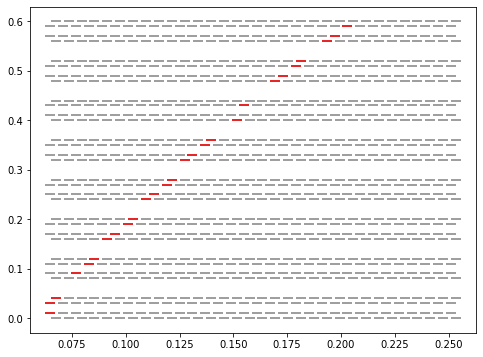

In [17]:
ev = generate_event(*toy)
#print(ev)
plot_event(ev)

$L = \Pi_{i=1}^8 \frac{1}{\sqrt{2\pi}\sigma} \exp(-\frac{(x_{meas}-x_{exp})^2}{2\sigma^2})$<br/>
$\log(L) = \sum_{i=1}^8 -\frac{(x_{meas}-x_{exp})^2}{2\sigma^2} - \log(\sqrt{2\pi}\sigma)$

In [18]:
#log-likelihoods

#using the "alternative" method here to make it easier, we know about the step structure now
def hit_pdf(x_meas,x,z,p):
    xs = calc_x(x,det_zs-z,p)

    llh = 0
    pmf=1
    
    for i,hit in enumerate(x_meas):
        #if we registered a hit
        if hit>0:
            #integrate Gaussian over bin area -> erf
            pmf *= 0.5*(erf((hit+2.5e-3-xs[i])/sigma/np.sqrt(2)) - erf((hit-2.5e-3-xs[i])/sigma/np.sqrt(2)))
        #if we didn't register a hit
        else:
            #if particle doesn't reach layer
            if xs[i] < 0:
                continue #pmf *= 1
            else:
                #determine closest gaps: n, n-1, n+1
                n = (xs[i]+5.5e-3)//6e-3
                pmf_s = 0
                for m in [n-1, n, n+1]:
                    gap_end = m*6e-3 + 0.5e-3
                    #integrate over gap
                    pmf_s += 0.5*(erf((gap_end-xs[i])/sigma/np.sqrt(2)) - erf((gap_end-1e-3-xs[i])/sigma/np.sqrt(2)))
                pmf *= pmf_s
    if pmf==0: llh=-710
    else: llh = np.log(pmf)    
    
    #store negative LLH, multiply by -1
    return -llh

In [19]:
grid_spacing = 100

#full range
xs = np.linspace(-2.5e-2, 2.5e-2, grid_spacing)
zs = np.linspace(-1, -0.5, grid_spacing)
ps = np.linspace(0.5, 3.0, grid_spacing)

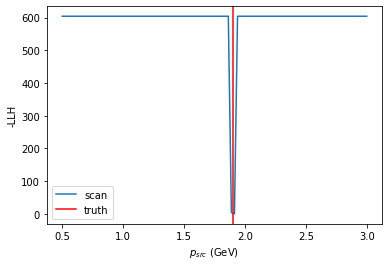

In [20]:
llh_p_scan = map_1d(hit_pdf, ev, 2, ps, toy)

plot_1d_scan(llh_p_scan, ps, p_toy, '$p_{src}$ (GeV)')

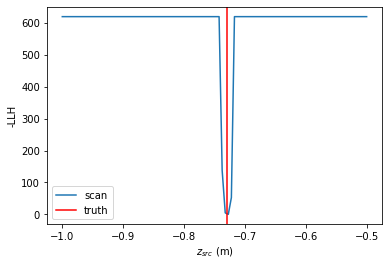

In [21]:
llh_z_scan = map_1d(hit_pdf, ev, 1, zs, toy)

plot_1d_scan(llh_z_scan, zs, z_toy, '$z_{src}$ (m)')

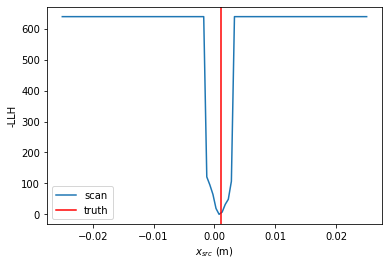

In [22]:
llh_x_scan = map_1d(hit_pdf, ev, 0, xs, toy)

plot_1d_scan(llh_x_scan, xs, x_toy, '$x_{src}$ (m)')

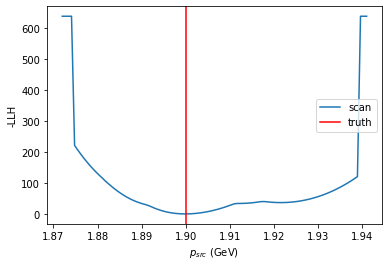

In [23]:
#zooming in
p_zoom = (1.872,1.941)
#p_zoom = (2.237,2.348)
ps = np.linspace(*p_zoom, grid_spacing)

llh_p_scan = map_1d(hit_pdf, ev, 2, ps, toy)

plot_1d_scan(llh_p_scan, ps, p_toy, '$p_{src}$ (GeV)')

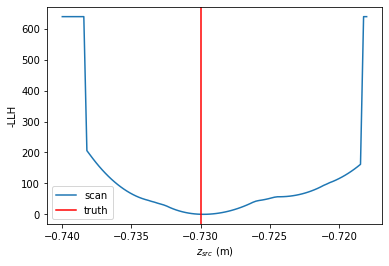

In [24]:
z_zoom = (-0.740,-0.718)
#z_zoom = (-0.653,-0.627)
zs = np.linspace(*z_zoom, grid_spacing)

llh_z_scan = map_1d(hit_pdf, ev, 1, zs, toy)

plot_1d_scan(llh_z_scan, zs, z_toy, '$z_{src}$ (m)')

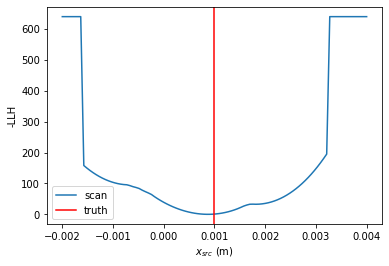

In [25]:
x_zoom = (-0.002, 0.004)
#x_zoom = (-0.013, -0.007)
xs = np.linspace(*x_zoom, grid_spacing)

llh_x_scan = map_1d(hit_pdf, ev, 0, xs, toy)

plot_1d_scan(llh_x_scan, xs, x_toy, '$x_{src}$ (m)')

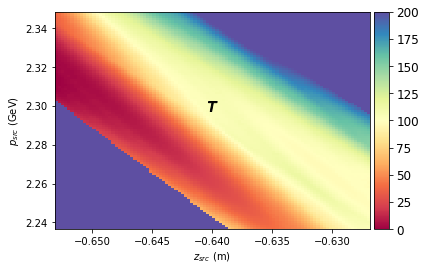

In [217]:
llh_z_p_scan = map_2d(hit_pdf, ev, (1, 2), (zs,ps), toy)

plot_2d_scan(llh_z_p_scan, zs,ps,z_toy, p_toy,
                   axis_labels=['$z_{src}$ (m)','$p_{src}$ (GeV)'],vmax=200)

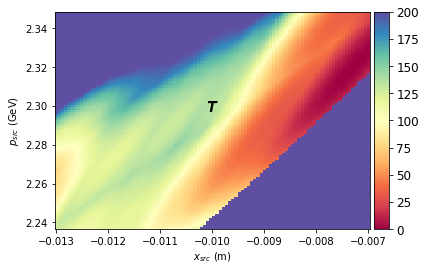

In [218]:
llh_x_p_scan = map_2d(hit_pdf, ev, (0, 2), (xs, ps), toy)

plot_2d_scan(llh_x_p_scan, xs, ps, x_toy, p_toy,
                   axis_labels=['$x_{src}$ (m)', '$p_{src}$ (GeV)'],vmax=200)

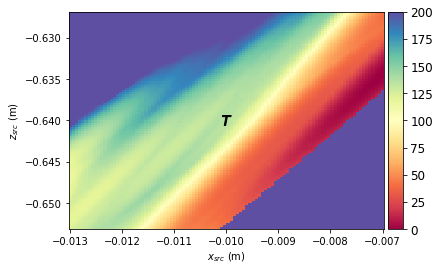

In [219]:
llh_x_z_scan = map_2d(hit_pdf, ev, (0, 1), (xs,zs), toy)

plot_2d_scan(llh_x_z_scan, xs, zs, x_toy, z_toy,
                   axis_labels=['$x_{src}$ (m)', '$z_{src}$ (m)'],vmax=200)

In [8]:
#make toy MC data for neural net training
N_mc = int(1e6)
mc, truth = MC_events(N_mc,verbose_lvl=2)

# events done: 0
# events to go: 1000000
100000 events done
100000 events done
100000 events done
100000 events done
100000 events done
100000 events done
100000 events done
100000 events done
100000 events done
# events thrown out: 2941
# events done: 997059
# events to go: 2941
# events thrown out: 10
# events done: 999990
# events to go: 10
100000 events done
# events thrown out: 0


In [9]:
#neural nets

hitnet = types.SimpleNamespace() 

hitnet.events = mc

#separate the hits into single events, add the detector z position
hitnet.events = np.concatenate(hitnet.events)
hitnet.events = np.vstack((hitnet.events,np.tile(det_zs,N_mc))).T

hitnet.truth = np.repeat(truth, N_det, axis=0)

assert hitnet.events.shape[0] == hitnet.truth.shape[0]

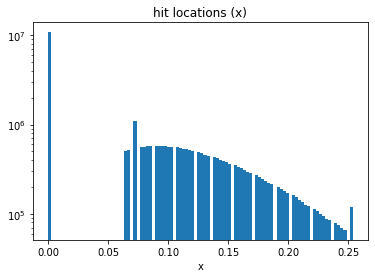

In [10]:
#histogram of hit positions (x) = bin centers
plt.hist(hitnet.events[:,0], bins=100)
plt.gca().set_yscale('log')
plt.title('hit locations (x)')
plt.xlabel('x')
plt.show()

In [11]:
#need trafo to combine measurements and (hypothetical) input params into input for NN
class trafo(tf.keras.layers.Layer):

    def call(self, hits, theta):
        out = tf.stack([
                 hits[:,0],
                 hits[:,1],
                 theta[:,0],
                 theta[:,1],
                 theta[:,2]
                ],
                axis=1
                )
#        out = tf.concat([charges[:,:1],r2,theta],axis=1)
        return out

hitnet.trafo = trafo

In [12]:
#make training and test datasets
hitnet.x_train, hitnet.x_test, hitnet.t_train, hitnet.t_test = train_test_split(hitnet.events, hitnet.truth, test_size=0.2, random_state=42)
hitnet.d_train = make_dataset(hitnet.x_train, hitnet.t_train)
hitnet.d_test = make_dataset(hitnet.x_test, hitnet.t_test)

In [13]:
## Neural Net

activation='relu'

x_input = tf.keras.Input(shape=(hitnet.x_train.shape[1],))
t_input = tf.keras.Input(shape=(hitnet.t_train.shape[1],))

h = hitnet.trafo()(x_input, t_input)

#h = tf.keras.layers.Dense(16, activation=activation)(h)
#h = tf.keras.layers.Dropout(0.01)(h)

h = tf.keras.layers.Dense(32, activation=activation)(h)
h = tf.keras.layers.Dropout(0.01)(h)

h = tf.keras.layers.Dense(64, activation=activation)(h)
h = tf.keras.layers.Dropout(0.01)(h)

h = tf.keras.layers.Dense(128, activation=activation)(h)
h = tf.keras.layers.Dropout(0.01)(h)

h = tf.keras.layers.Dense(64, activation=activation)(h)
h = tf.keras.layers.Dropout(0.01)(h)

h = tf.keras.layers.Dense(32, activation=activation)(h)
h = tf.keras.layers.Dropout(0.01)(h)

#h = tf.keras.layers.Dense(16, activation=activation)(h)
#h = tf.keras.layers.Dropout(0.01)(h)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(h)

hitnet.model = tf.keras.Model(inputs=[x_input, t_input], outputs=outputs)
hitnet.model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 3)]          0                                            
__________________________________________________________________________________________________
trafo (trafo)                   (None, 5)            0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 32)           192         trafo[0][0]                  

In [14]:
optimizer = tf.keras.optimizers.Adam(0.001)
hitnet.model.compile(loss='binary_crossentropy', optimizer=optimizer)

In [15]:
#training

hitnet.hist = hitnet.model.fit(hitnet.d_train, epochs=5, verbose=1, validation_data=hitnet.d_test)

Epoch 1/5
12500/12500 [==============================] - 5470s 438ms/step - loss: 0.3495 - val_loss: 0.2853
Epoch 2/5
12500/12500 [==============================] - 667s 53ms/step - loss: 0.2961 - val_loss: 0.2751
Epoch 3/5
12500/12500 [==============================] - 657s 53ms/step - loss: 0.2904 - val_loss: 0.3103
Epoch 4/5
12500/12500 [==============================] - 3263s 261ms/step - loss: 0.2874 - val_loss: 0.2762
Epoch 5/5
12500/12500 [==============================] - 740s 59ms/step - loss: 0.2829 - val_loss: 0.2691


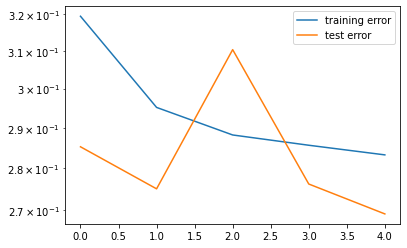

In [26]:
plt.plot(hitnet.model.history.history['loss'],label='training error')
plt.plot(hitnet.model.history.history['val_loss'],label='test error')
plt.gca().set_yscale('log')
plt.legend()
plt.show()

#compile neural net
#log(sigmoid) = linear -> change last layer to get llh
hitnet.llh = tf.keras.models.clone_model(hitnet.model)
hitnet.llh.set_weights(hitnet.model.get_weights())
hitnet.llh.layers[-1].activation = tf.keras.activations.linear
hitnet.llh.compile()

In [27]:
#full range
xs = np.linspace(-2.5e-2, 2.5e-2, grid_spacing)
zs = np.linspace(-1, -0.5, grid_spacing)
ps = np.linspace(0.5, 3.0, grid_spacing)

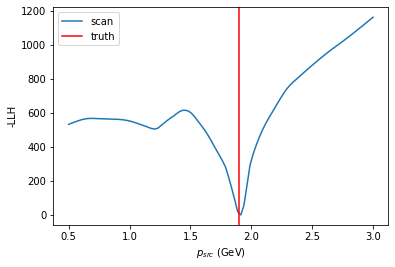

In [28]:
#neural net scan
#p_zoom = np.array([-0.05,0.05]) + p_toy #0.1
#ps = np.linspace(*p_zoom,grid_spacing)

scan_t = np.vstack([np.ones(grid_spacing)*x_toy,np.ones(grid_spacing)*z_toy,ps]).T
scan_t = np.repeat(scan_t,N_det,axis=0)

scan_x = np.tile(ev,grid_spacing)
scan_x = np.vstack((scan_x,np.tile(det_zs,grid_spacing))).T

nn_p_scan = hitnet.llh.predict([scan_x,scan_t])

nn_p_scan = -np.sum(nn_p_scan.reshape(-1,N_det),axis=1)
plot_1d_scan(nn_p_scan, ps, p_toy, axis_label='$p_{src}$ (GeV)')

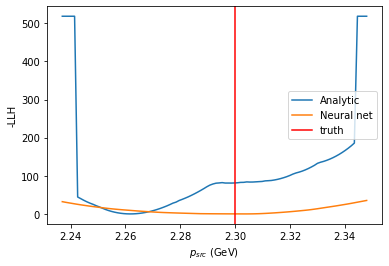

In [221]:
#comparison NN and analytical
#llh_p_scan = map_1d(hit_pdf, ev, 2, ps, toy)

plot_1d_diff(llh_p_scan, nn_p_scan, ps, p_toy, '$p_{src}$ (GeV)')

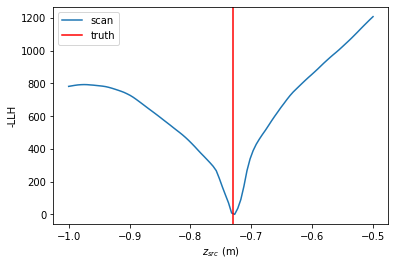

In [29]:
#neural net scan
#z_zoom = np.array([-0.01,0.01]) + z_toy #0.015
#zs = np.linspace(*z_zoom,grid_spacing)

scan_t = np.vstack([np.ones(grid_spacing)*x_toy,zs,np.ones(grid_spacing)*p_toy]).T
scan_t = np.repeat(scan_t,N_det,axis=0)

nn_z_scan = hitnet.llh.predict([scan_x,scan_t])

nn_z_scan = -np.sum(nn_z_scan.reshape(-1,N_det),axis=1)
plot_1d_scan(nn_z_scan, zs, z_toy, axis_label='$z_{src}$ (m)')

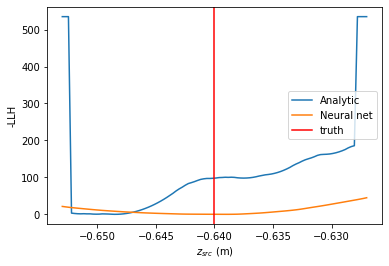

In [223]:
#comparison NN and analytical
#x_zoom = np.array([-0.003,0.003]) + x_toy
#llh_z_scan = map_1d(hit_pdf, ev, 1, zs, toy)

plot_1d_diff(llh_z_scan, nn_z_scan, zs, z_toy, '$z_{src}$ (m)')

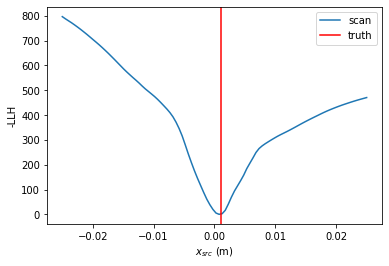

In [30]:
#neural net scan
#xs = np.linspace(*x_zoom,grid_spacing)

scan_t = np.vstack([xs,np.ones(grid_spacing)*z_toy,np.ones(grid_spacing)*p_toy]).T
scan_t = np.repeat(scan_t,N_det,axis=0)

nn_x_scan = hitnet.llh.predict([scan_x,scan_t])

nn_x_scan = -np.sum(nn_x_scan.reshape(-1,N_det),axis=1)
plot_1d_scan(nn_x_scan, xs, x_toy, axis_label='$x_{src}$ (m)')

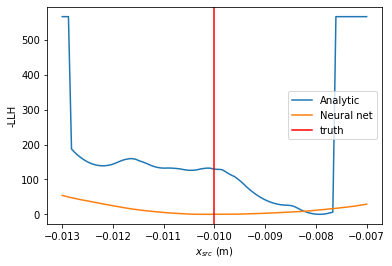

In [225]:
#comparison NN and analytical
#llh_x_scan = map_1d(hit_pdf, ev, 0, xs, toy)

plot_1d_diff(llh_x_scan, nn_x_scan, xs, x_toy, '$x_{src}$ (m)')

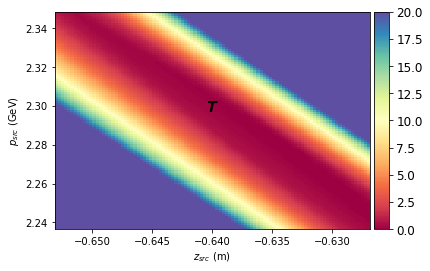

In [226]:
#neural net scan
mg = np.meshgrid(zs,ps)

hitnet.grid_t = np.vstack([np.ones(grid_spacing**2)*x_toy,mg[0].flatten(),mg[1].flatten()]).T
hitnet.grid_t = np.repeat(hitnet.grid_t,N_det,axis=0)

hitnet.grid_x = np.tile(ev,grid_spacing**2)
hitnet.grid_x = np.vstack((hitnet.grid_x,np.tile(det_zs,grid_spacing**2))).T

hitnet.grid_llh = hitnet.llh.predict([hitnet.grid_x,hitnet.grid_t])

NN_z_p_scan = -np.sum(hitnet.grid_llh.reshape(-1, N_det), axis=1)
plot_2d_scan(NN_z_p_scan, zs, ps, z_toy, p_toy, 
            axis_labels=['$z_{src}$ (m)', '$p_{src}$ (GeV)'],vmax=20)

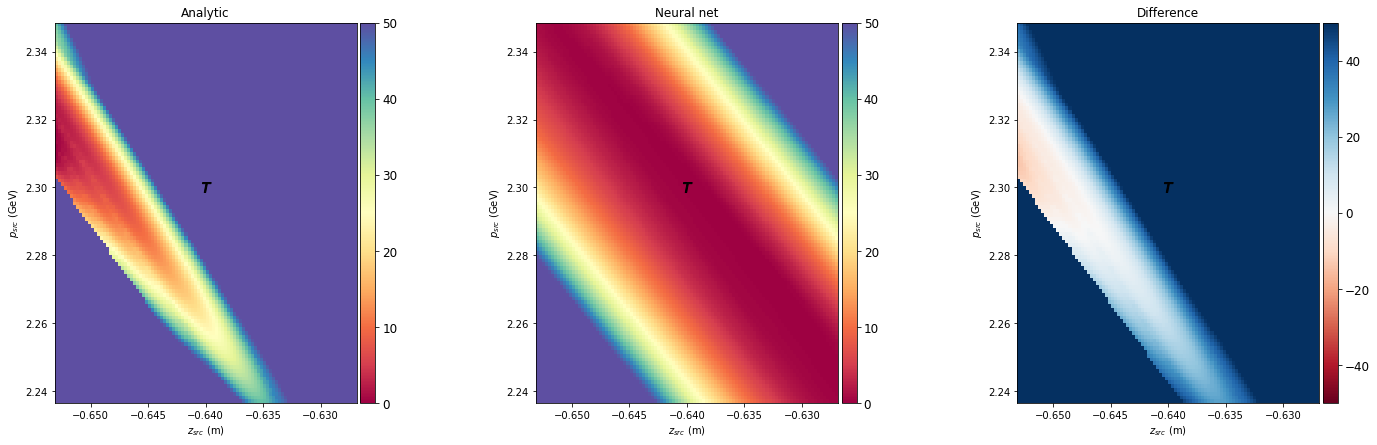

In [227]:
#comparison
#llh_z_p_scan = map_2d(ev, (1, 2), (zs,ps),x_toy, z_toy, p_toy)

plot_2d_diff(llh_z_p_scan, NN_z_p_scan, zs, ps, z_toy, p_toy,
             axis_labels=['$z_{src}$ (m)', '$p_{src}$ (GeV)'],vmax=50,vmax_d=50)

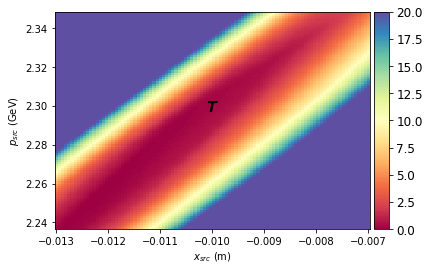

In [228]:
#neural net scan
mg = np.meshgrid(xs,ps)

hitnet.grid_t = np.vstack([mg[0].flatten(),np.ones(grid_spacing**2)*z_toy,mg[1].flatten()]).T
hitnet.grid_t = np.repeat(hitnet.grid_t,N_det,axis=0)

hitnet.grid_llh = hitnet.llh.predict([hitnet.grid_x,hitnet.grid_t])

NN_x_p_scan = -np.sum(hitnet.grid_llh.reshape(-1, N_det), axis=1)
plot_2d_scan(NN_x_p_scan, xs, ps, x_toy, p_toy, 
            axis_labels=['$x_{src}$ (m)', '$p_{src}$ (GeV)'],vmax=20)

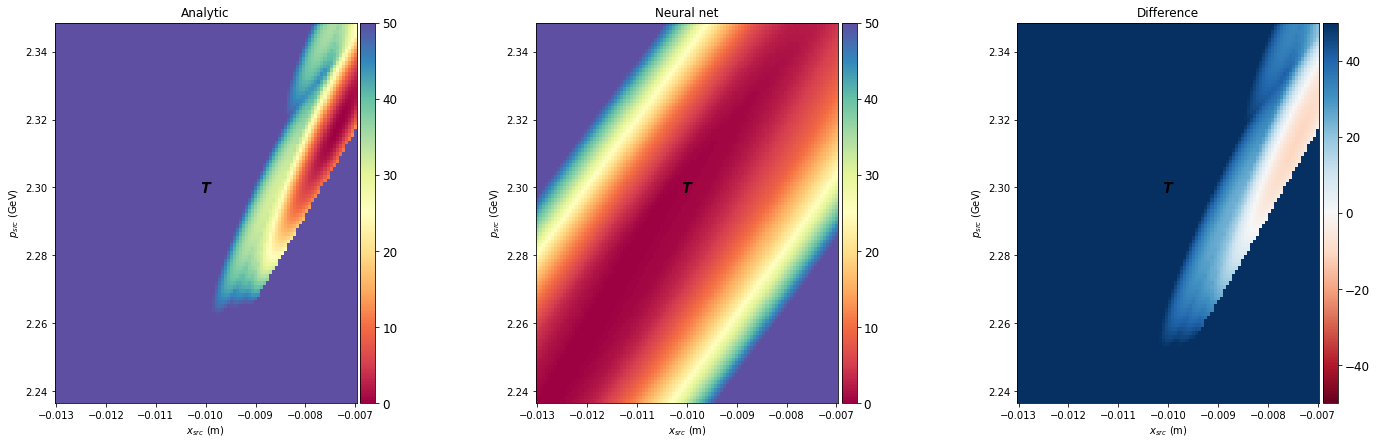

In [229]:
#comparison
#llh_x_p_scan = map_2d(hit_pdf, ev, (0,2), (xs,ps), toy)

plot_2d_diff(llh_x_p_scan, NN_x_p_scan, xs, ps, x_toy, p_toy,
             axis_labels=['$x_{src}$ (m)', '$p_{src}$ (GeV)'],vmax=50,vmax_d=50)

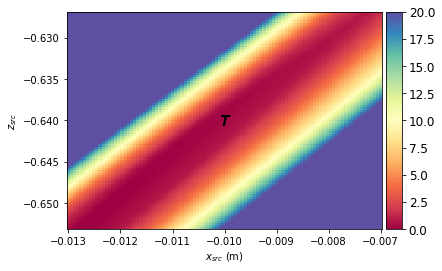

In [230]:
#neural net scan
mg = np.meshgrid(xs,zs)

hitnet.grid_t = np.vstack([mg[0].flatten(),mg[1].flatten(),np.ones(grid_spacing**2)*p_toy]).T
hitnet.grid_t = np.repeat(hitnet.grid_t,N_det,axis=0)

hitnet.grid_llh = hitnet.llh.predict([hitnet.grid_x,hitnet.grid_t])

NN_x_z_scan = -np.sum(hitnet.grid_llh.reshape(-1, N_det), axis=1)
plot_2d_scan(NN_x_z_scan, xs, zs, x_toy, z_toy, 
            axis_labels=['$x_{src}$ (m)', '$z_{src}$'],vmax=20)

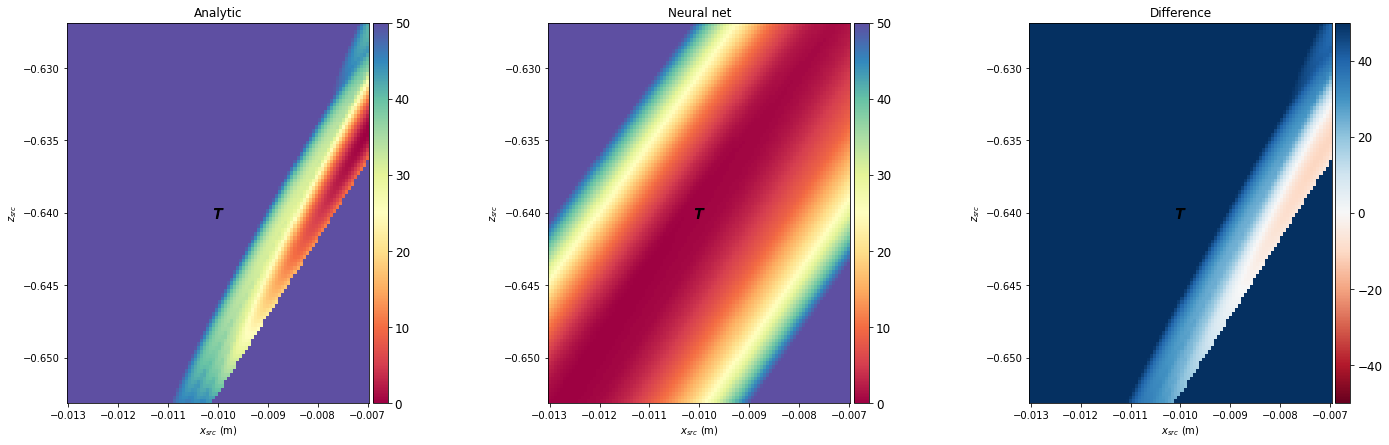

In [231]:
#comparison
#llh_x_z_scan = map_2d(ev, (0, 1), (xs,zs), x_toy, z_toy, p_toy)

plot_2d_diff(llh_x_z_scan, NN_x_z_scan, xs, zs, x_toy, z_toy,
             axis_labels=['$x_{src}$ (m)', '$z_{src}$'],vmax=50,vmax_d=50)

In [232]:
#minimize analytic likelihood
def ana_llh(theta,event):
    #wrapper funtion
    return hit_pdf(event,*theta)

print(*toy)
true_llh_ana = ana_llh(toy,ev)
print(true_llh_ana)

-0.01 -0.64 2.3
272.83726696958036


In [233]:
#minimize nn output
def nn_llh(theta, event):
    #wrapper function
    
    #reshape events into 8x2 array 
    event = np.vstack((event,det_zs)).T

    #repeat truth for each hit in event
    theta = np.array(theta)
    theta = np.repeat(theta[np.newaxis,:], N_det, axis=0)

    #let neural net predict llh for each event, sum is total llh
    pred = hitnet.llh.predict([event,theta])
    return -1*pred.sum()

print(*toy)
true_llh_nn = nn_llh(toy,ev)
print(true_llh_nn)

-0.01 -0.64 2.3
-53.73988723754883


In [68]:
def bound_min(min_fct, x0, bounds, ev):
    #run a bound minimizer
    
    #x0 starting guess
    #bounds must be list of tuples, len = len(x0)
    opt_params = minimize(min_fct,x0,args=(ev),method='Powell',bounds=bounds,options={'maxiter':100000})
    
    print("starting guess:",x0)
    if opt_params.success:
        print("function value:",opt_params.fun)
        print("\nerrors:")
        print("x (mm):",1000*(opt_params.x[0]-x_toy))
        print("z (mm):",1000*(opt_params.x[1]-z_toy))
        print("p (MeV):",1000*(opt_params.x[2]-p_toy))
        print("\nrelative error (%):")
        print(100*(opt_params.x - [x_toy,z_toy,p_toy])/[x_toy,z_toy,p_toy])
        print("\n")
        
    else: print("Minimization failed!")
        
    return opt_params.fun, opt_params.x

In [234]:
#minimize analytic llh with different starting guesses
_, opt_ana = bound_min(ana_llh,[x_zoom[0],z_zoom[0],p_zoom[0]],[x_zoom,z_zoom,p_zoom],ev)
_, opt_ana = bound_min(ana_llh,[x_zoom[1],z_zoom[1],p_zoom[1]],[x_zoom,z_zoom,p_zoom],ev)
#try truth as starting guess, see where we land (assume that's global min)
f_ana, opt_ana = bound_min(ana_llh,toy,[x_zoom,z_zoom,p_zoom],ev)

starting guess: [-0.013, -0.653, 2.237]
function value: 152.661138951884

errors:
x (mm): 2.4256469968215644
z (mm): 9.637490429224904
p (MeV): -33.48169663675016

relative error (%):
[-24.25646997  -1.50585788  -1.45572594]


starting guess: [-0.007, -0.627, 2.348]
function value: 137.4525818584556

errors:
x (mm): 1.8559485618293379
z (mm): -10.428916916347397
p (MeV): 46.57628477783105

relative error (%):
[-18.55948562   1.62951827   2.02505586]


starting guess: [-0.01, -0.64, 2.3]
function value: 137.9933948418134

errors:
x (mm): 2.8745027943896524
z (mm): 2.5084108103947678
p (MeV): 11.969502632652063

relative error (%):
[-28.74502794  -0.39193919   0.52041316]




For events with many hits: pretty good results overall, about 1mm off in x no matter what starting guess, which is probably as good as it'll get.

For events with fewer hits: truth is definitely not actual minimum (see scans). Results are all relatively far off from truth, which is to be expected, but also far off from each other - many local minima to get stuck in?

In [235]:
#minimize NN output with different starting guesses
f_nn, opt_nn = bound_min(nn_llh,[x_zoom[0],z_zoom[0],p_zoom[0]],[x_zoom,z_zoom,p_zoom],ev)
if f_nn<=true_llh_nn:
    print("LLH of truth (NN/ana):",true_llh_nn, true_llh_ana)
    print("NN llh of found min:",f_nn)
    print("Analytic llh of found min (NN/ana):",ana_llh(opt_nn,ev),f_ana)

starting guess: [-0.013, -0.653, 2.237]
function value: -53.97418212890625

errors:
x (mm): -2.937452823629786
z (mm): -0.4342942651660575
p (MeV): -62.942394917057776

relative error (%):
[29.37452824  0.06785848 -2.73662587]


LLH of truth (NN/ana): -53.73988723754883 272.83726696958036
NN llh of found min: -53.97418212890625
Analytic llh of found min (NN/ana): 262.62794893294455 137.9933948418134


In [236]:
f_nn, opt_nn = bound_min(nn_llh,[x_zoom[1],z_zoom[1],p_zoom[1]],[x_zoom,z_zoom,p_zoom],ev)
if f_nn<=true_llh_nn:
    print("LLH of truth (NN/ana):",true_llh_nn, true_llh_ana)
    print("NN llh of found min:",f_nn)
    print("Analytic llh of found min (NN/ana):",ana_llh(opt_nn,ev),f_ana)

starting guess: [-0.007, -0.627, 2.348]
function value: -54.009765625

errors:
x (mm): -1.863464918241518
z (mm): 3.0645582954303974
p (MeV): -50.98434812149799

relative error (%):
[18.63464918 -0.47883723 -2.21671079]


LLH of truth (NN/ana): -53.73988723754883 272.83726696958036
NN llh of found min: -54.009765625
Analytic llh of found min (NN/ana): 268.0889967955239 137.9933948418134


In [237]:
f_nn, opt_nn = bound_min(nn_llh,toy,[x_zoom,z_zoom,p_zoom],ev)
if f_nn<=true_llh_nn:
    print("LLH of truth (NN/ana):",true_llh_nn, true_llh_ana)
    print("NN llh of found min:",f_nn)
    print("Analytic llh of found min (NN/ana):",ana_llh(opt_nn,ev),f_ana)

starting guess: [-0.01, -0.64, 2.3]
function value: -53.87547302246094

errors:
x (mm): -0.25783286051794113
z (mm): 0.08170922923578239
p (MeV): 0.06195358903449133

relative error (%):
[ 2.57832861 -0.01276707  0.00269363]


LLH of truth (NN/ana): -53.73988723754883 272.83726696958036
NN llh of found min: -53.87547302246094
Analytic llh of found min (NN/ana): 273.1990513712378 137.9933948418134


For events with many hits: NN performs better than analytic when starting from truth, less than 1mm error in x. Performs ok for other starting guesses but error in z is significantly larger than analytic result.

For events with fewer hits, the NN performs ok-ish overall, very well when starting from truth; better than analytic in most cases. Does NN pick up something that's hidden in the data?